In [3]:
setwd("C:/Users/User/Documents/Meus Arquivos/Códigos")
source("Funções.R")

In [4]:
options(warn = -1)
pacotes <- c("tidyquant", "tidyverse", "rugarch", "PerformanceAnalytics", "rmgarch", "bizdays")
for(i in pacotes){
  suppressPackageStartupMessages(library(i, character.only = T))
}

In [5]:
benchmark <- "^BVSP"
acoes <- c("B3SA3.SA","MGLU3.SA","VALE3.SA")
acoes <- c(acoes,benchmark)
#Coletando os preços das ações e colocando em mesma escala
precos <- tq_get(acoes, from = "2017-05-01")
precos_mat <- precos %>%
  group_by(date, symbol) %>%
  summarise(adjusted) %>%
  spread(key = symbol, value = adjusted) %>%
  na.omit
data <- (precos_mat$date)
precos_mat[,1] <- NULL
precos_mat <- as.matrix(precos_mat)
for(i in 1:ncol(precos_mat)){
  precos_mat[,i] <- precos_mat[,i]/precos_mat[1,i]
}

`summarise()` regrouping output by 'date' (override with `.groups` argument)



In [6]:
#Pegando os dados do benchmark
ibov <- precos_mat[,1]
precos_mat <- precos_mat[,-1]

In [14]:
pesos <- c(0.684,0.178,0.138)
carteira <- matrix(0, nrow = nrow(precos_mat), ncol = 1)
dif <- diff(precos_mat)/precos_mat[2:nrow(precos_mat)-1,]
for(i in 1:nrow(dif)){
  carteira[i+1,] <- sum(dif[i,]*pesos, na.rm = T)
}
carteira <- cumprod(carteira+1)
carteira_hold <- matrix(0, ncol = 1, nrow = nrow(precos_mat))
for(i in 1:nrow(carteira_hold)){
  carteira_hold[i,] <- sum(precos_mat[i,]*pesos)
}

In [15]:
sum(pesos)

[1] 1

In [16]:
var_c <- diff(carteira)/carteira[2:length(carteira)-1]
var_h <- diff(carteira_hold)/carteira_hold[2:nrow(carteira_hold)-1,]
var_ibov <- diff(ibov)/ibov[2:length(ibov)-1]
tx_livre <- 0.02
beta_h <- cov(var_h, var_ibov)/sd(var_ibov)^2
beta_c <- cov(var_c, var_ibov)/sd(var_ibov)^2
alpha_h <- (mean(var_h)*252-tx_livre)-beta_h*(mean(var_ibov)*252-tx_livre)
alpha_c <- (mean(var_c)*252-tx_livre)-beta_c*(mean(var_ibov)*252-tx_livre)

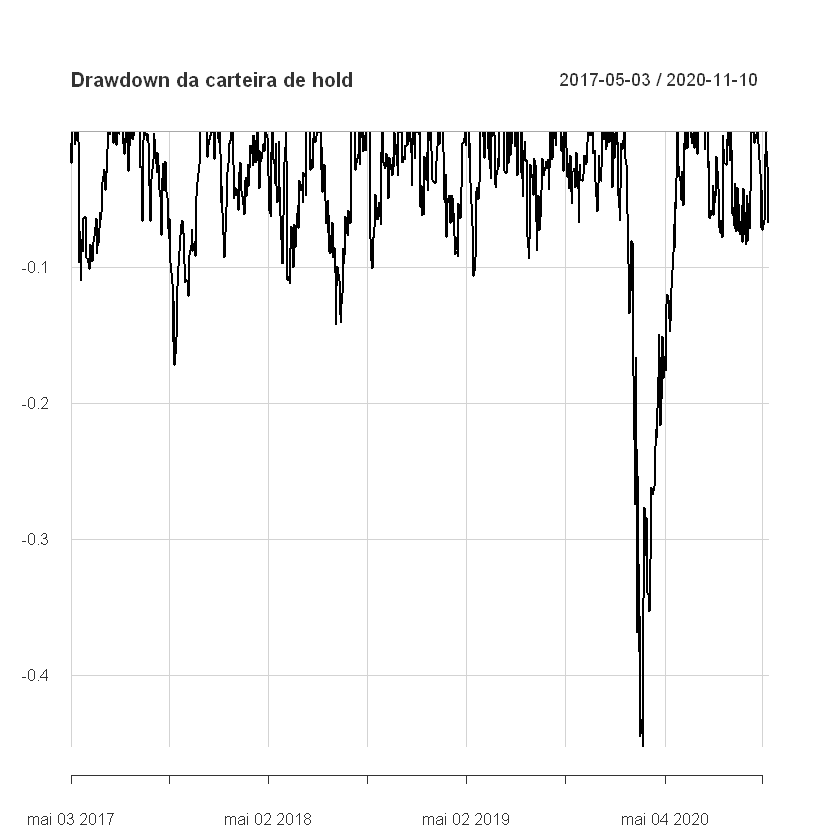

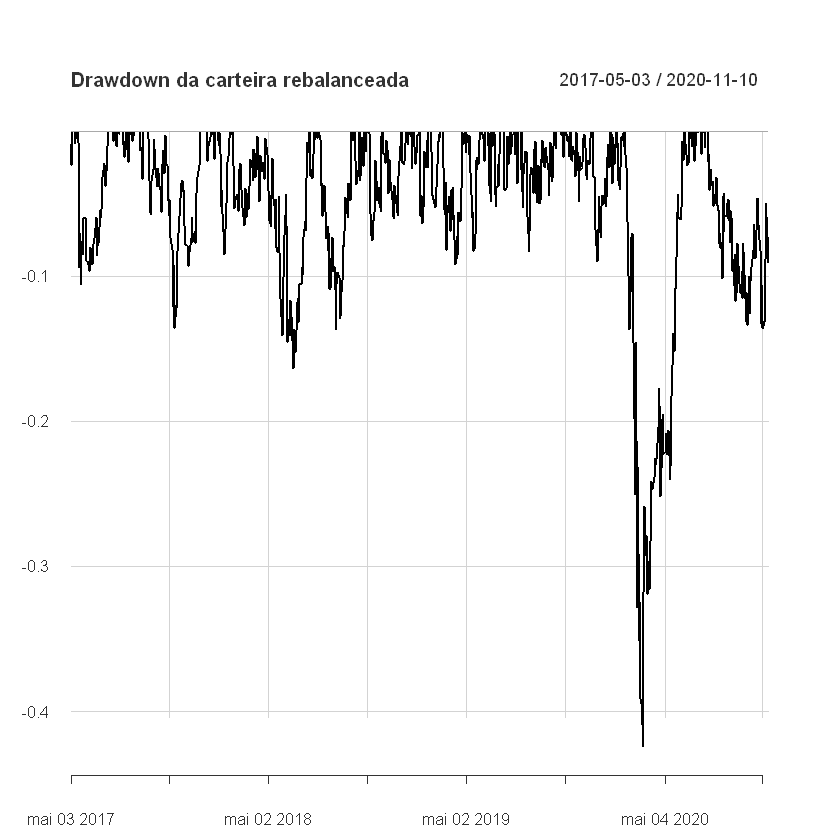

In [17]:
#Drawdown das carteiras
var_c <- xts(var_c, data[2:length(data)])
colnames(var_c) <- "Carteira rebalanceada"
var_h <- xts(var_h, data[2:length(data)])
colnames(var_h) <- "Carteira Buy And Hold"
var_ibov <- xts(var_ibov, order.by = data[2:length(data)])
chart.Drawdown(var_h, main = "Drawdown da carteira de hold")
chart.Drawdown(var_c, main = "Drawdown da carteira rebalanceada")

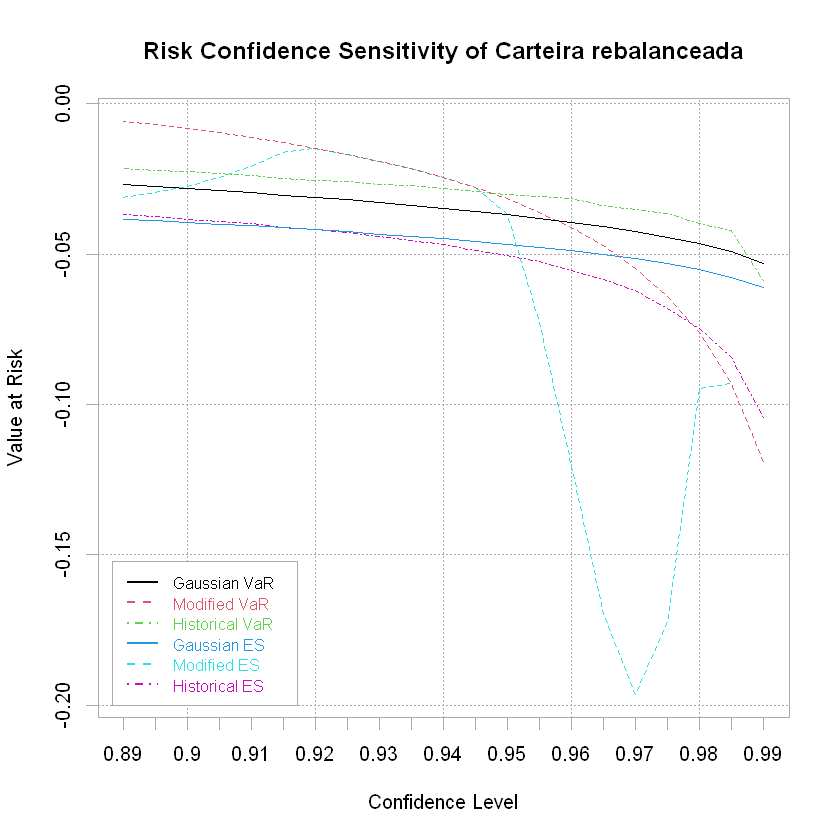

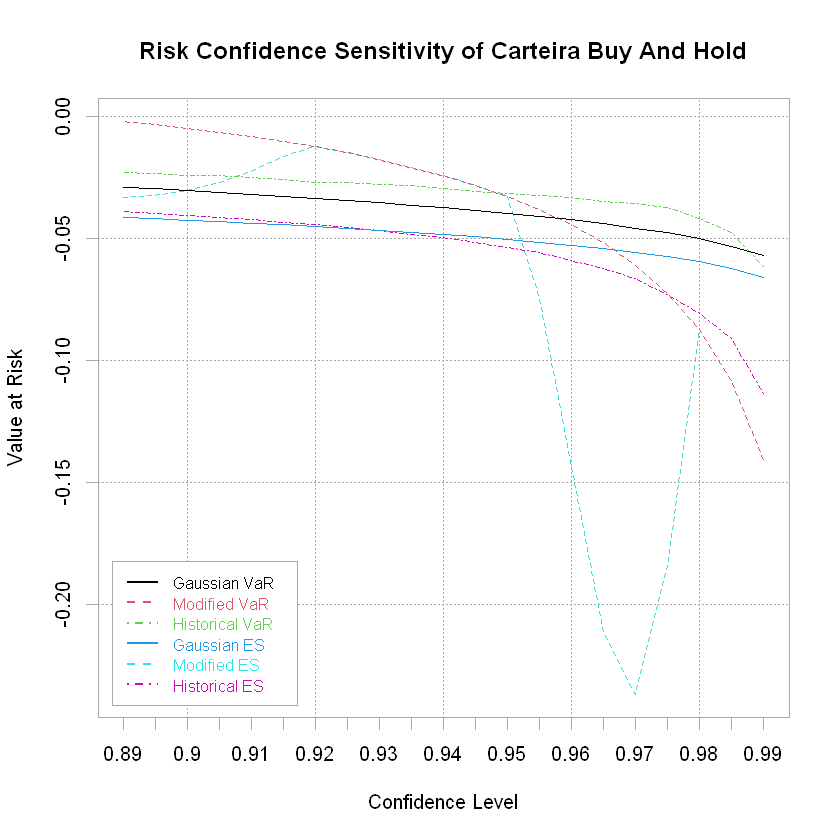

In [18]:
#VaR das carteiras
chart.VaRSensitivity(var_c)
chart.VaRSensitivity(var_h)

In [19]:
preco_dt <- data.frame(date = data,Hold = carteira_hold, 
                       Rebalanceada = carteira, Benchmark = ibov)%>%
  gather(key = "Carteiras", value = "Precos", -date)

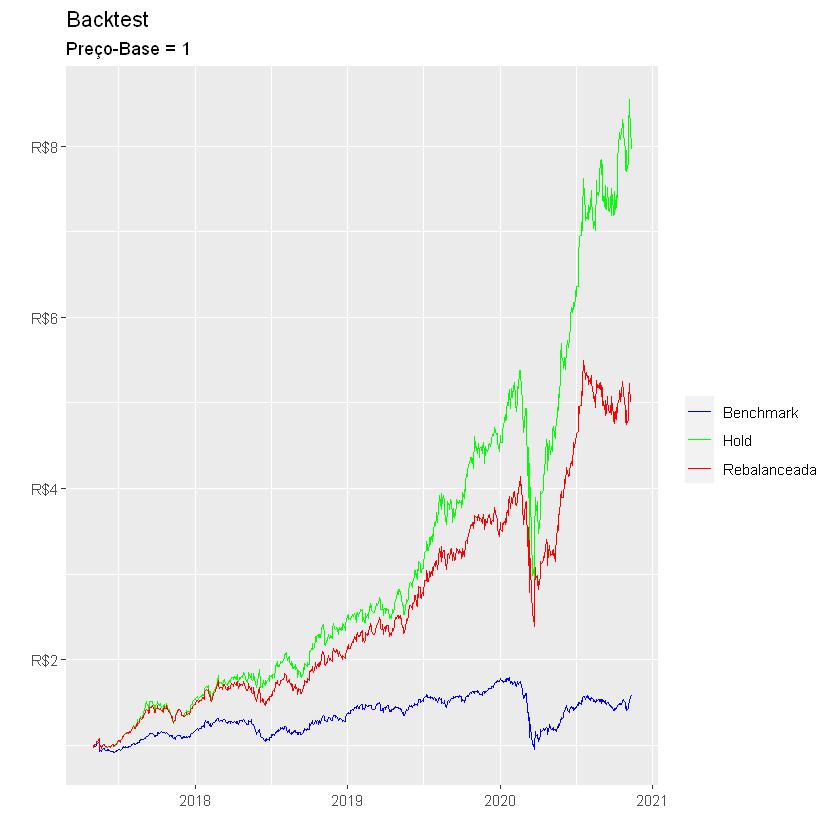

In [20]:
ggplot(preco_dt, aes(x = date, y = Precos, col = Carteiras))+
  geom_line()+
  scale_y_continuous(labels = scales::dollar_format(prefix = "R$"))+
  labs(x = "", y = "", title = "Backtest", subtitle = "Preço-Base = 1")+
  scale_colour_manual("", values = c("blue","green", "red"))

In [21]:
#Sharpe
tx_l <- 0.02
sharpe_h <- (mean(var_h)*252-tx_l)/(sd(var_h)*sqrt(252))
sharpe_c <- (mean(var_c)*252-tx_l)/(sd(var_c)*sqrt(252))
paste("Sharpe Rebalanceado =",round(sharpe_c,2))
paste("Sharpe Buy & Hold =",round(sharpe_h,2))
sharpe_h_a <- (mean(xts::last(var_h),252)*252-tx_l)/(sd(xts::last(var_h,252))*sqrt(252))
sharpe_c_a <- (mean(xts::last(var_c),252)*252-tx_l)/(sd(xts::last(var_c,252))*sqrt(252))
paste("Sharpe do último ano Rebalanceado =",round(sharpe_c_a,2))
paste("Sharpe do último ano Buy & Hold =",round(sharpe_h_a,2))

[1] "Sharpe Rebalanceado = 1.37"

[1] "Sharpe Buy & Hold = 1.63"

[1] "Sharpe do último ano Rebalanceado = -2.45"

[1] "Sharpe do último ano Buy & Hold = -13.48"

In [23]:
#Alpha
paste0("Alpha Rebalanceado = ",round(alpha_c*100,3),"%")
paste0("Alpha Buy & Hold = ",round(alpha_h*100,3),"%")

[1] "Alpha Rebalanceado = 34.399%"

[1] "Alpha Buy & Hold = 48.562%"

In [24]:
#Tracking Error
te_h <- sqrt(sum((var_h-var_ibov)^2)/length(var_h))
paste0("Tracking Error Buy and Hold = ",round(te_h*100,3),"%")
te_c <- sqrt(sum((var_c-var_ibov)^2)/length(var_c))
paste0("Tracking Error Rebalanceamento = ",round(te_c*100,3),"%")

[1] "Tracking Error Buy and Hold = 1.487%"

[1] "Tracking Error Rebalanceamento = 1.209%"

In [25]:
#Beta
beta_h <- as.numeric(beta_h)
names(beta_h) <- "Beta Hold"
names(beta_c) <- "Beta Rebalanceado"
print(beta_h, digits = 3)
print(beta_c, digits = 3)

Beta Hold 
     1.15 
Beta Rebalanceado 
             1.11 


In [26]:
traynor_h <- (mean(var_h)*252-tx_l)/beta_h
traynor_c <- (mean(var_c)*252-tx_l)/beta_c
traynor_tot <- c(traynor_h, traynor_c)
names(traynor_tot) <- c("Traynor Hold","Traynor Rebalanceado")
print(traynor_tot, digits = 2)

        Traynor Hold Traynor Rebalanceado 
                0.58                 0.47 


In [27]:
#var_h = Variação da carteira hold var_c = Variação da carteira rebalanceada
arch <- suppressMessages(find_best_arch_model(na.omit(var_h),
                             dist_to_use = c("norm","snorm"), min_GARCH = 1, min_ARCH = 1,
                         type_models = c("sGARCH","eGARCH")))

In [28]:
ugspec <- arch$ugspec_b
ugfit <- ugarchfit(ugspec, na.omit(var_h))

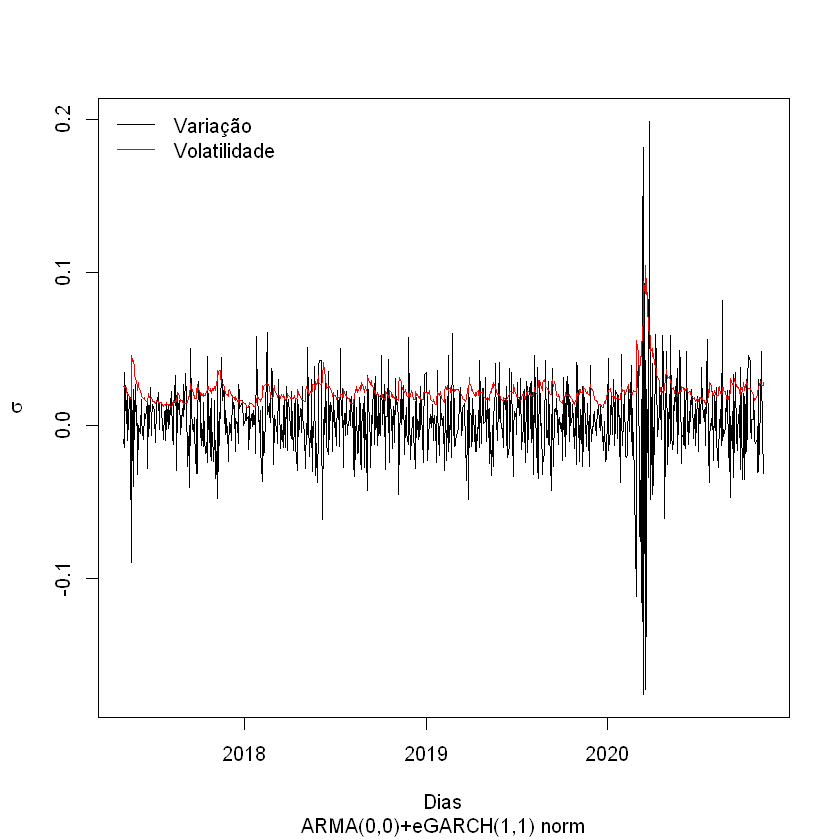

In [29]:
plot(data[2:nrow(precos_mat)],as.numeric(var_h), type = "l",
     sub = arch$best_bic$model_name, xlab = "Dias",ylab = expression(sigma, mu))
lines(data[2:nrow(precos_mat)],ugfit@fit$sigma, col = "red")
legend("topleft", legend = c("Variação", "Volatilidade"),
       lty = c(1,1), col = c("black","red"),
       bty = "n")

In [30]:
#VaR test
alpha <- 0.05
VaRTest(alpha, actual = var_h, VaR = quantile(ugfit, alpha))

$expected.exceed
[1] 43

$actual.exceed
[1] 41

$uc.H0
[1] "Correct Exceedances"

$uc.LRstat
[1] 0.1601642

$uc.critical
[1] 3.841459

$uc.LRp
[1] 0.6890054

$uc.Decision
[1] "Fail to Reject H0"

$cc.H0
[1] "Correct Exceedances & Independent"

$cc.LRstat
[1] 4.217308

$cc.critical
[1] 5.991465

$cc.LRp
[1] 0.1214013

$cc.Decision
[1] "Fail to Reject H0"

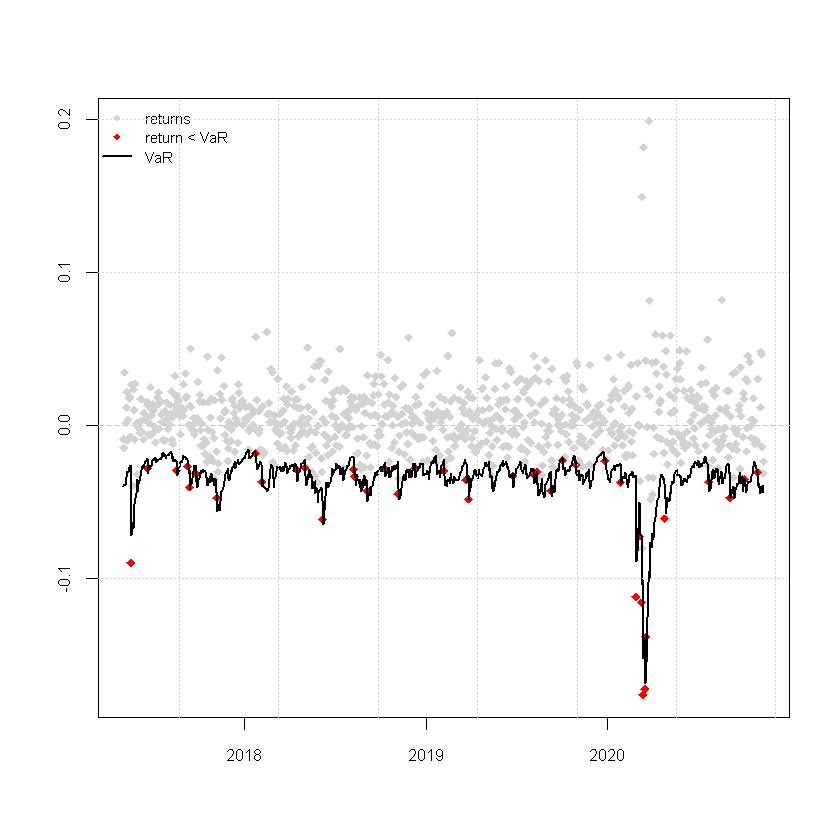

In [31]:
#VaR plot
VaRplot(alpha = alpha,actual = var_h, VaR = quantile(ugfit, alpha))

In [32]:
dias <- 252
simulacoes <- 5000

In [33]:
ugsim <- ugarchsim(ugfit, n.sim = simulacoes, m.sim = dias)
sim <- t(ugsim@simulation$seriesSim)
sim <- sim+1
sim <- apply(sim,2,cumprod)

In [34]:
data_sim <- bizdays::bizseq(Sys.Date()+1, Sys.Date()+365*10, "Brazil/ANBIMA")[1:dias]

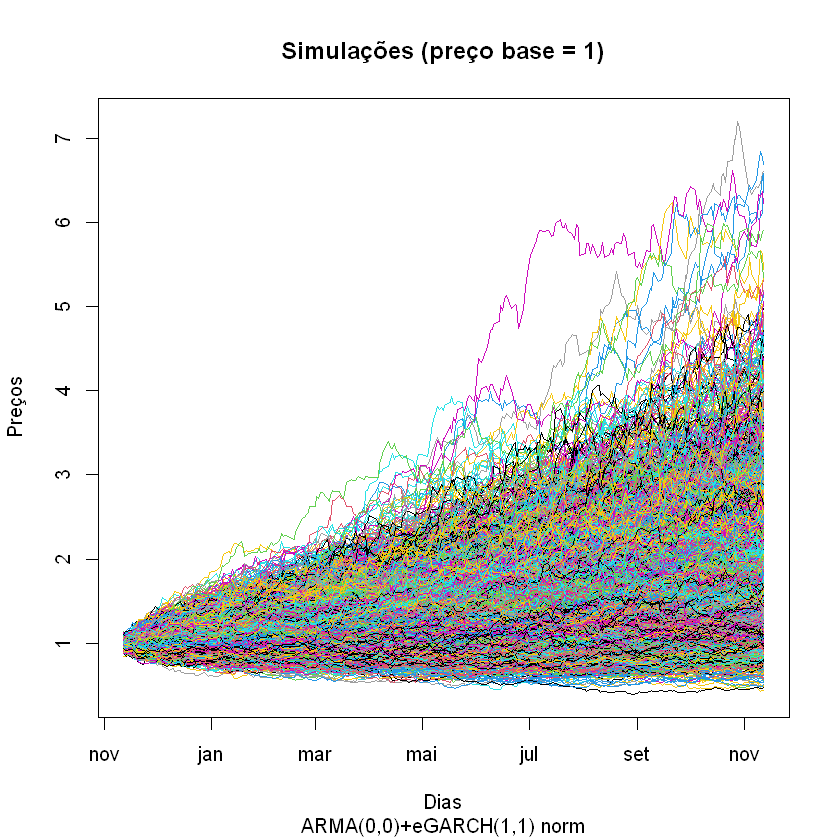

In [35]:
matplot(data_sim,sim, type = "l", lty = 1, col = 1:ncol(sim),
        xlab = "Dias", ylab = "Preços",
        main = "Simulações (preço base = 1)",
        sub = arch$best_bic$model_name)

`summarise()` ungrouping output (override with `.groups` argument)



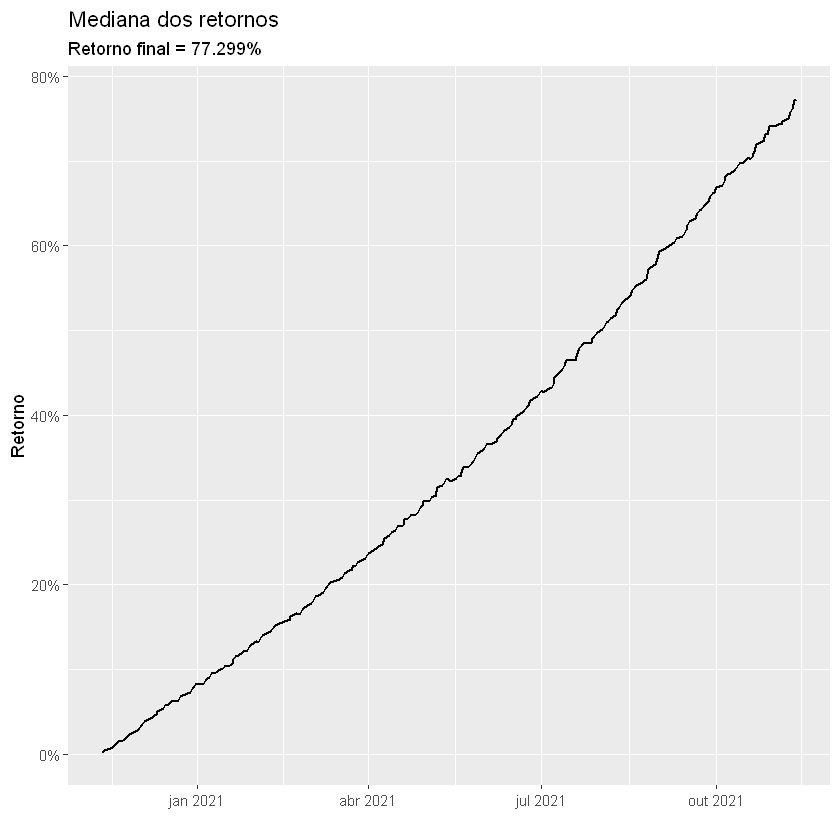

In [36]:
mediana <- sim %>%
  as.data.frame() %>%
  mutate(periodo = data_sim) %>%
  gather(key = "key", value = "value", -periodo) %>%
  group_by(periodo) %>%
  summarise(mediana = median(value)-1)
ggplot(mediana, aes(x = periodo, y = mediana))+
  geom_line(size = 0.7)+
  scale_y_continuous(labels = scales::percent)+
  labs(x = "", y = "Retorno", title = "Mediana dos retornos",
       subtitle = paste0("Retorno final = ", round(xts::last(mediana$mediana)*100,3),"%"))

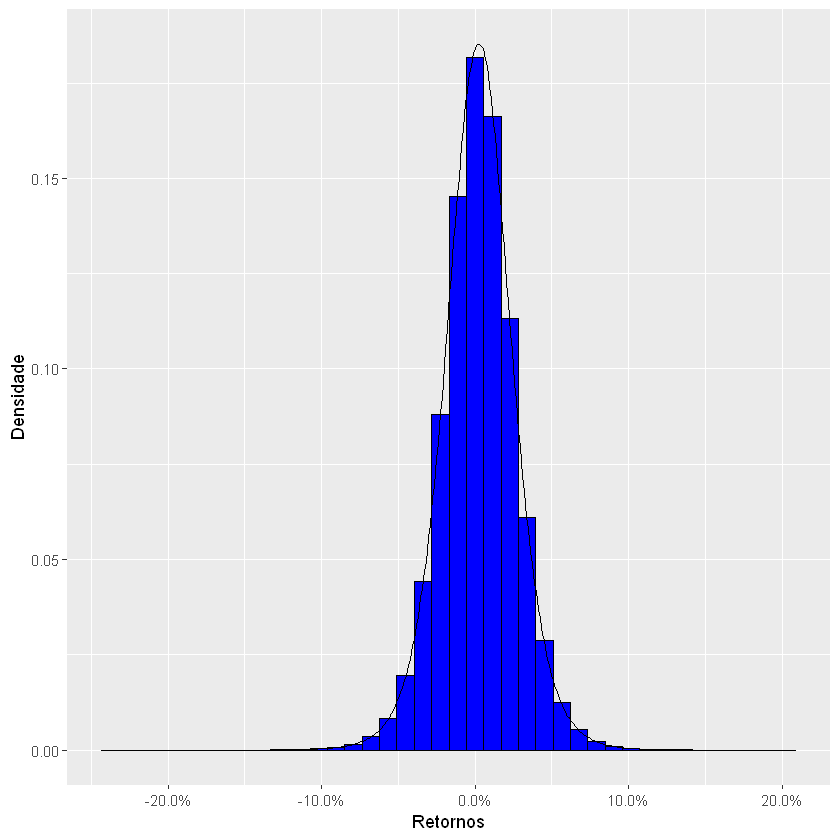

In [37]:
dif <- diff(sim)/sim[2:nrow(sim)-1,] %>% as.data.frame()
v <- dif %>%
  gather()
v %>%
  ggplot(aes(x = value, y = after_stat(density)/100))+
  geom_histogram(bins = 40, col = "black", fill = "blue")+
  geom_density()+
  labs(x = "Retornos", y = "Densidade")+
  scale_x_continuous(labels = scales::percent)

In [38]:
#VaR da simulação
var <- round(quantile(v$value, prob = c(0.05,0.01))*100,3)
print(var)

    5%     1% 
-3.611 -5.748 


In [39]:
#VaR Histórico
round(quantile(var_h, prob = c(0.05,0.01), na.rm = T)*100,3) %>% print

    5%     1% 
-3.129 -6.130 


In [40]:
mínimo <- round((min(sim)-1)*100,3)
máximo <- round((max(sim)-1)*100,3)
names(mínimo) <- "Retorno Mínimo"
names(máximo) <- "Retorno Máximo"
paste0("Retorno Mínimo = ",mínimo,"%")
paste0("Retorno Máximo = ", máximo,"%")

[1] "Retorno Mínimo = -61.23%"

[1] "Retorno Máximo = 620.571%"

`summarise()` ungrouping output (override with `.groups` argument)



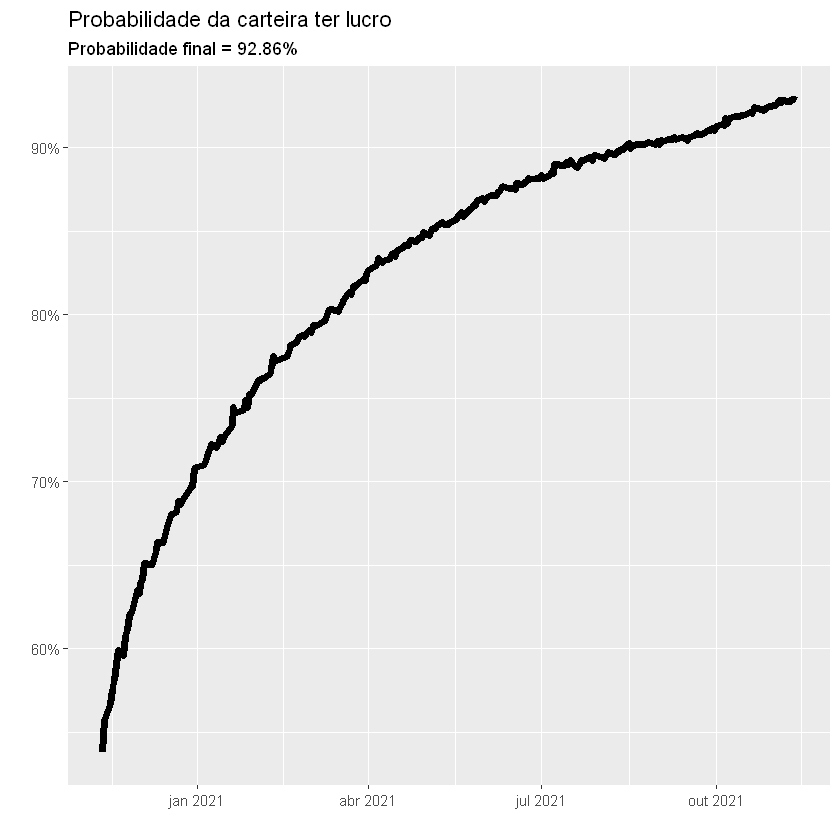

In [41]:
prob <- sim %>%
  as.data.frame() %>%
  mutate(periodo = data_sim) %>%
  gather(key = "key", value = "value",-periodo) %>%
  group_by(periodo) %>%
  summarise(prob = mean(value > 1))
prob %>%
  ggplot(aes(x = periodo, y = prob))+
  geom_line(size = 2)+
  labs(x = "", y = "", title = "Probabilidade da carteira ter lucro",
      subtitle = paste0("Probabilidade final = ",round(xts::last(prob$prob)*100,3), "%"))+
  scale_y_continuous(labels = scales::percent)

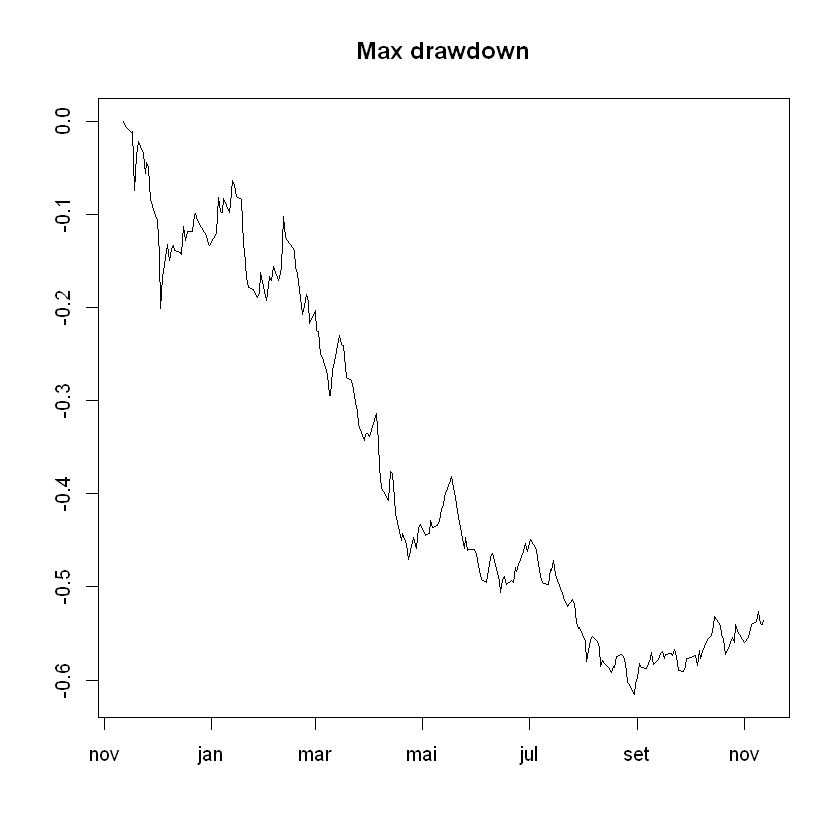

In [42]:
#Max Drawdrown
maxs <- apply(sim,2,cummax)
draw <- matrix(nrow = nrow(sim), ncol = ncol(sim))
for(i in 1:ncol(draw)){
  draw[,i] <- sim[,i]/maxs[,i]-1
}
mins <- apply(draw,2,min)
plot(data_sim,draw[,which.min(mins)], type = "l", xlab = "", ylab = "", main = "Max drawdown")

In [43]:
#Mean Drawdown
paste0("Mean Drawdown = ",round(mean(draw)*100, 3),"%")

[1] "Mean Drawdown = -8.018%"

In [44]:
med <- (coef(ugfit)["mu"]*252)
sd_c <- xts::last(sigma(ugfit)*sqrt(252))
tx_livre <- 0.02
data1 <- data.frame(Retorno = med, Risco = sd_c, Sharpe = (med-tx_livre)/sd_c)

In [45]:
data1

,Retorno,Risco,Sharpe
,<dbl>,<dbl>,<dbl>
mu,0.6344218,0.4490801,1.368179


In [46]:
var_tot <- cbind(var_h,var_ibov)

In [47]:
arch1 <- suppressMessages(apply(var_tot,2,find_best_arch_model,
                               dist_to_use = c("snorm","std"), min_GARCH = 1, min_ARCH = 1,
                               type_model = c("sGARCH","eGARCH")))
multi <- replicate(2,list())
for(i in 1:length(multi)){
  multi[[i]] <- arch1[[i]]$ugspec_b
}

In [48]:
multspec <- multispec(multi)
multf <- multifit(multispec = multspec, data = var_tot)
best <- suppressMessages(find_best_dcc_model(var_tot,
                                             uspec = multspec,
                                             dist_to_use = c("mvnorm","mvt")))
spec1 <- best$dccspec_b
fit1 <- dccfit(spec1, data = var_tot, fit = multf, fit.control = list(eval.se = T))

In [49]:
coefs <- numeric(length = ncol(var_tot))
for(i in 1:length(coefs)){
  coefs[i] <- multf@fit[[i]]@fit$coef["mu"]*252
}
cov1 <- rcov(fit1)
cova <- cov1[1,2,]
sd <- matrix(0, nrow = nrow(var_tot), ncol = ncol(var_tot))
for(i in 1:ncol(var_tot)){
  sd[,i] <- multf@fit[[i]]@fit$sigma
}

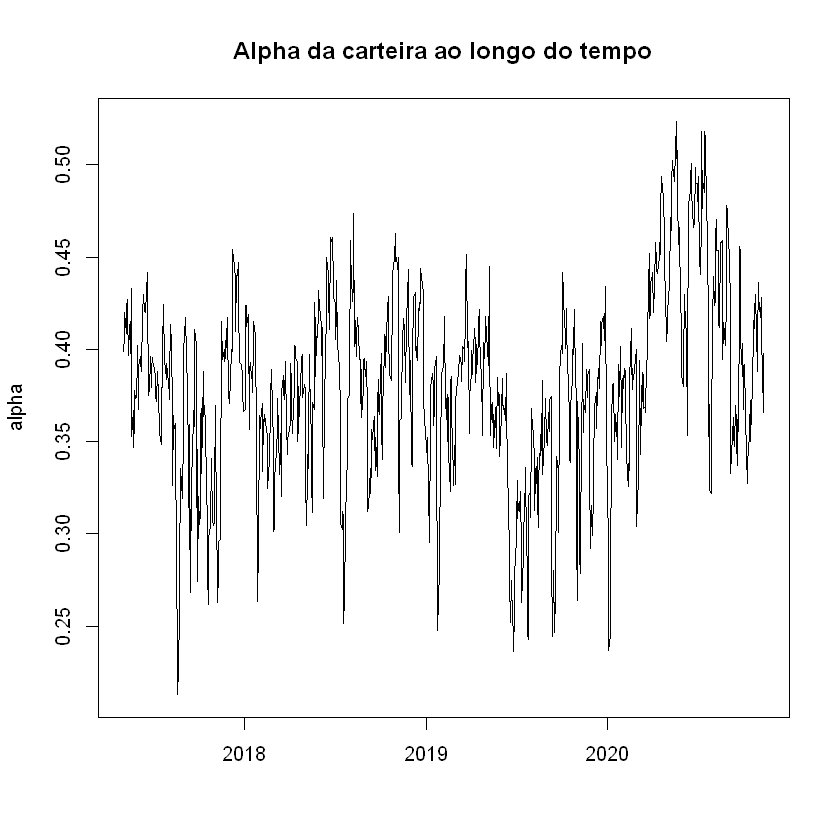

In [50]:
beta <- cova/sd[,2]^2
alpha <- (coefs[1]-tx_livre)-beta*(coefs[2]-tx_livre)
plot(data[2:length(data)],alpha, type = "l", main = "Alpha da carteira ao longo do tempo", xlab = "")

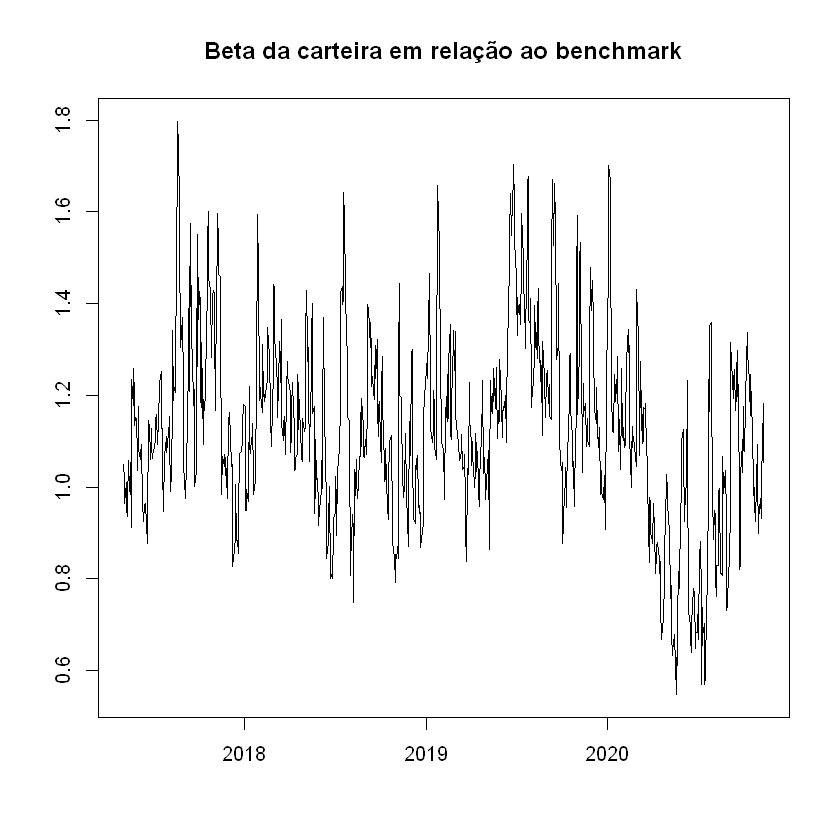

In [51]:
plot(data[2:length(data)],beta,
     type = "l",
     main = "Beta da carteira em relação ao benchmark",
     xlab = "",
     ylab = "")

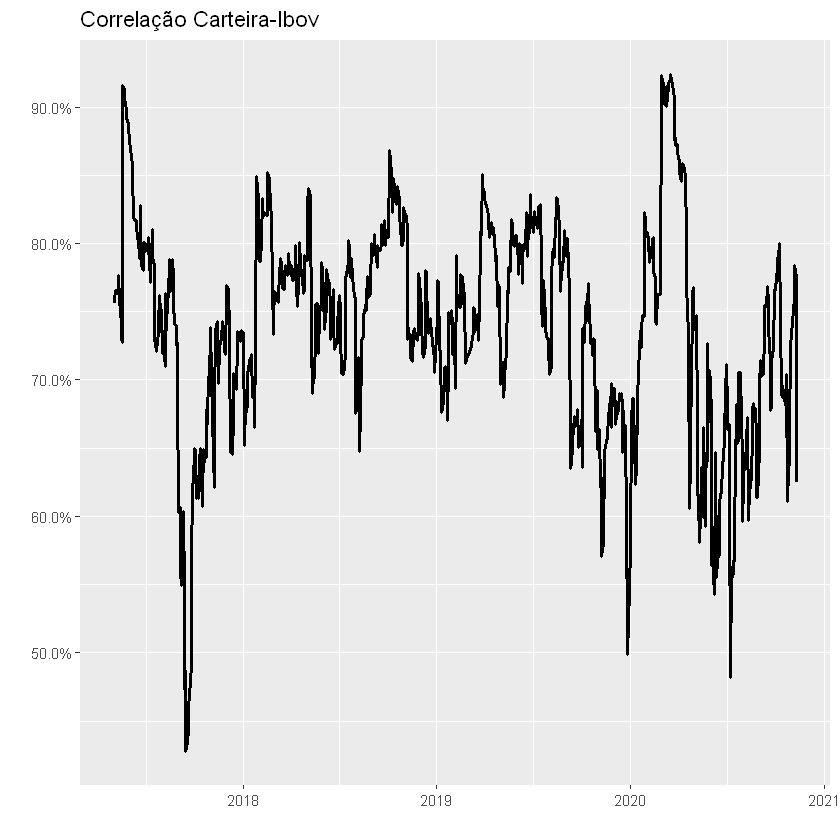

In [55]:
corr <- rcor(fit1)[1,2,]
corre <- data.frame(date = data[2:length(data)], cor = corr)
ggplot(corre, aes(x = date, y = cor))+
    geom_line(size = 1)+
    labs(x = "", y = "", title = "Correlação Carteira-Ibov")+
    scale_y_continuous(labels = scales::percent)